![molprop](https://storage.googleapis.com/polaris-public/icons/icons8-fox-60-kinases.png)

## RET wild type Benchmark 


### Background
**RET (Rearranged during Transfection)** is a proto-oncogene that codes for a receptor tyrosine kinase. This means it produces a protein that plays a role in signaling pathways within cells, particularly related to cell growth and differentiation. When activated, RET helps regulate cell survival, proliferation, and differentiation. Mutations or alterations in the RET gene can lead to uncontrolled cell growth and potentially the development of cancer.

### Benchmarking
- **RET wild type**: In some cases, targeting both mutant and wild-type RET together can be more effective than targeting only one form as Combination Therapies. In certain cancer types, such as some subtypes of non-small cell lung cancer (NSCLC), the RET signaling pathway can interact with other oncogenic pathways, such as the EGFR (epidermal growth factor receptor) pathway. Targeting both pathways simultaneously might offer a synergistic effect and improve treatment outcomes.

The goal of this benchmark is to select the best predictive model for 
- Optimization of the bioactivity % inhibition.
- Discovery of potential hits in new chemical space.



### Description of readout 
- **Readouts**: `RET`
- **Bioassay readout**: percentage of inhibition.
- **Optimization objective**: Higher inhibition


### Data resource: 
- **Reference**: [PKIS2](https://www.ncbi.nlm.nih.gov/pubmed/28767711)

### Train/test split
Given the benchmarking goal, a scaffold-based splitting approach was applied to ensure training and test sets contain distinct chemical structures while maintaining the diversity of scaffolds.


In [1]:
import pandas as pd
import datamol as dm
import numpy as np
from sklearn.model_selection import ShuffleSplit
import polaris
from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.benchmark import (
    SingleTaskBenchmarkSpecification,
    MultiTaskBenchmarkSpecification,
)
import warnings

warnings.filterwarnings("ignore")
import os
import pathlib

os.chdir(pathlib.Path("__file__").absolute().parents[2])
from utils import *

In [2]:
BENCHMARK_DIR = "gs://polaris-public/benchmarks/kinases/ret"
FIGURE_DIR = "gs://polaris-public/datasets/kinases/ret/figures"

## Load existing dataset object
> **Attention:** \
> The original dataset is published in https://www.ncbi.nlm.nih.gov/pubmed/28767711 \
> 
> To **maintain consistency** with other benchmarks in the Polaris Hub, a thorough data curation process is carried out to ensure the accuracy of molecular presentations.
> Therefore, the raw data from the data resource is not used here. 
> See more curation details in [here](https://github.com/polaris-hub/polaris-recipes/blob/mvp/03_Kinases/RET).


In [3]:
dataset = polaris.load_dataset(
    "gs://polaris-public/datasets/kinases/pkis2_subset_curated /pkis2_egfr_ret_kit_lok_slk_v1/dataset.json"
)

In [4]:
# Display dataset
dataset

{
  "name": "pkis2_egfr_ret_kit_lok_slk_v1",
  "description": "A subset of PKIS 2 dataset only including EGFR, RET, KIT, LOK and SLK kinases. Profile of kinases PKIS2 which contains 640 small molecule for 468 kinases.",
  "tags": [
    "Kinase",
    "HitDiscovery",
    "Selectivity"
  ],
  "user_attributes": {},
  "owner": {
    "slug": "polaristest",
    "organization_id": "PolarisTest",
    "user_id": null,
    "owner": "PolarisTest"
  },
  "md5sum": "e221702e985aafa8859d279addb6d39f",
  "readme": "![molprop](https://storage.googleapis.com/polaris-public/icons/icons8-fox-60-kinases.png)\n\n## Backgroud:\n Kinases play a crucial role in cellular signalling, making them important targets for drug development. Dysregulation of kinases is frequently implicated in diseases like cancer, inflammation, and neurodegenerative disorders. Therefore, targeting kinases with specific drugs has emerged as a crucial strategy in modern drug discovery. Kinase-related task includes inhibition prediction, selectivity prediction, or kinase-ligand binding affinity prediction. In the early release version of Polaris, benchmarks were established for kinases such as EGFR, KIT, and RET, along with their respective mutations, as well as for LOK and SLK.\n\n\n## Description of readout \n- **Readouts**: `EGFR`, `KIT`, `RET`, `LOK`, `SLK`\n- **Bioassay readout**: Percentage of inhibition (%).\n- **Optimization objective**: Higher potency (higher %inhibition).\n\n\n## Data resource:\nPKIS2: A second chemogenomics set of kinase inhibitors from GSK, Takeda, and Pfizer was assembled as PKIS2. This set contained 645 inhibitors and included many additional chemotypes that were not represented in the original set.\n\n**Reference**: https://www.ncbi.nlm.nih.gov/pubmed/28767711\n\n<!-- ## Related benchmarks -->\n<!-- TODO: to be added -->\n\n<!-- ## Related benchmarks\nTODO: to be added -->",
  "annotations": {
    "UNIQUE_ID": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {}
    },
    "smiles": {
      "is_pointer": false,
      "modality": "MOLECULE",
      "description": null,
      "user_attributes": {}
    },
    "EGFR": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {
        "unit": "%",
        "concentration": "1uM",
        "organism": "Human",
        "objective": "Higher value",
        "source": "PKIS2",
        "mutation": "None",
        "target": "EGFR"
      }
    },
    "KIT": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {
        "unit": "%",
        "concentration": "1uM",
        "organism": "Human",
        "objective": "Higher value",
        "source": "PKIS2",
        "mutation": "None",
        "target": "KIT"
      }
    },
    "LOK": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {
        "unit": "%",
        "concentration": "1uM",
        "organism": "Human",
        "objective": "Higher value",
        "source": "PKIS2",
        "mutation": "None",
        "target": "LOK"
      }
    },
    "RET": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {
        "unit": "%",
        "concentration": "1uM",
        "organism": "Human",
        "objective": "Higher value",
        "source": "PKIS2",
        "mutation": "None",
        "target": "RET"
      }
    },
    "SLK": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {
        "unit": "%",
        "concentration": "1uM",
        "organism": "Human",
        "objective": "Higher value",
        "source": "PKIS2",
        "mutation": "None",
        "target": "SLK"
      }
    },
    "CLASS_EGFR": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {
        "

In [5]:
# data columns
data_cols = "RET"

<a id="benchmark"></a>
## Benchmark creation with `Polaris`
Creating a benchmark involves setting up a standard dataset, designing the train-validation-test set and defining evaluation metrics which is used to establish baseline performance level. 

In [6]:
from polaris.utils.types import HubOwner

owner = HubOwner(organizationId="PolarisTest", slug="polaristest")
owner.owner

'PolarisTest'

### Create scaffold split for `RET` dataset
> **Note:**
> Here we use splitting tool `Splito` to split dataset to train and test. \
> [Splito](https://github.com/datamol-io/splito) is a machine learning dataset splitting library for life sciences.

In [7]:
# scaffold split
from partitio._scaffold_split import ScaffoldSplit

flag = True
TEST_SIZE = 0.2
SEED = 177
splitter = ScaffoldSplit(
    smiles=dataset.table.smiles.values,
    n_jobs=-1,
    test_size=TEST_SIZE,
    random_state=SEED,
)
scaffold_split = next(splitter.split(X=dataset.table.smiles.values))

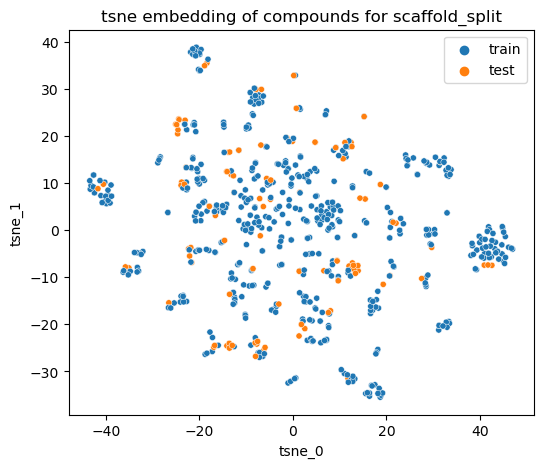

In [8]:
from utils import display_chemspace

data_name = "drewry_ret_wildtype_v1"
fig = display_chemspace(
    dataset.table.copy(), "smiles", split=scaffold_split, split_name="scaffold_split"
)
method = "tnse"
save_figure(
    fig,
    remote_path=f"{FIGURE_DIR}/{data_name}_{method}_scaffold_split.png",
    local_path=f"figures/{data_name}_{method}_scaffold_split.png",
)

## Single task for RET WT with scaffold split 

**Regression tasks**

In [9]:
benchmark_name = f"drewry_ret_wildtype_singletask_reg_v1"
BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"
data_cols = ["RET"]
benchmark_reg = SingleTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=data_cols,
    input_cols="smiles",
    split=scaffold_split,
    main_metric="mean_squared_error",
    metrics=[
        "mean_absolute_error",
        "mean_squared_error",
        "r2",
        "spearmanr",
        "pearsonr",
        "explained_var",
    ],
    tags=["Kinase", "SingleTask", "Regression", "HitDiscovery"],
    description="Singletask regression benchmark for RET wild type.",
    owner=owner,
    readme=load_readme(
        f"gs://polaris-public/readme/benchmarks/{benchmark_name}_readme.md"
    ),
)
path = benchmark_reg.to_json(BENCHMARK_SAVE_DIR)
print(path)

gs://polaris-public/benchmarks/kinases/ret/drewry_ret_wildtype_singletask_reg_v1/benchmark.json


**Classification tasks**

In [10]:
data_cols = ["CLASS_RET"]
benchmark_name = f"drewry_ret_wildtype_singletask_clf_v1"
BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"

benchmark_clf = SingleTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=data_cols,
    input_cols="smiles",
    split=scaffold_split,
    main_metric="pr_auc",
    metrics=["accuracy", "f1", "roc_auc", "pr_auc", "mcc", "cohen_kappa"],
    tags=["Kinase", "SingleTask", "Classification", "HitDiscovery"],
    description="Single task classification benchmark for RET wild type.",
    owner=owner,
    readme=load_readme(
        f"gs://polaris-public/readme/benchmarks/{benchmark_name}_readme.md"
    ),
)
path = benchmark_clf.to_json(BENCHMARK_SAVE_DIR)
print(path)

gs://polaris-public/benchmarks/kinases/ret/drewry_ret_wildtype_singletask_clf_v1/benchmark.json
